In [ ]:
from ultralytics import YOLO

In [ ]:
yolo = YOLO('../models/yolov8n-seg.pt', 'segment')

In [ ]:
yolo.train(data='./yolo-config.yaml', epochs=5, batch=4, workers=0)

In [ ]:
valid_results = yolo.val()

# Inference

In [ ]:
import cv2, PIL
from PIL import Image
from torchvision.transforms import functional as F
import matplotlib.pyplot as plt
import torch
import numpy as np
from ultralytics import YOLO

In [ ]:
image = cv2.imread('../data/images/clodding_train_005.jpg')

## Image transforms
https://chat.openai.com/share/480ee993-d561-4186-8b39-3a93acec8e3d

In [ ]:
yolo = YOLO('../runs/segment/train6/weights/best.pt', 'segment')

In [ ]:
res = yolo(image)


0: 544x640 13 ROCKs, 63.9ms
Speed: 4.2ms preprocess, 63.9ms inference, 102.8ms postprocess per image at shape (1, 3, 544, 640)


In [ ]:
def extract_points(mask): return mask.xy[0].astype(np.int32)[None]
    
def get_mask(result):
    '''get segmentation mask from yolo model'''
    res = np.zeros(result.orig_shape, dtype=np.uint8)
    for mask in result.masks:
        res = cv2.fillPoly(res, extract_points(mask), 255)
    return res

def merge_with_mask(image, mask, p=0.2, gamma=0):
    '''Merge together original image and segmentation mask'''
    mask_color = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)*np.array([0,1,0], np.uint8)
    return cv2.addWeighted(image, 1-p, mask_color, p, gamma)

<matplotlib.image.AxesImage>

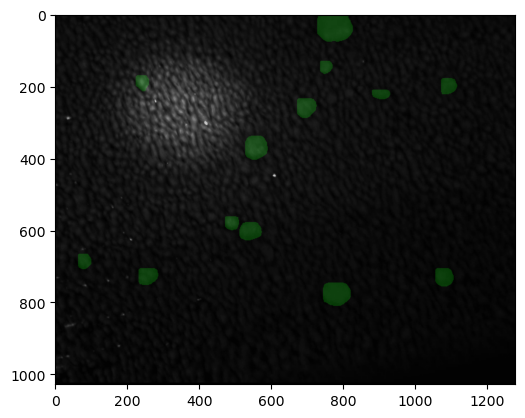

In [ ]:
mask = get_mask(res[0])
plt.imshow(merge_with_mask(image,mask))

## Area

In [ ]:
def poly_area_np(points):
    if not np.array_equal(points[0], points[-1]):
        points = np.concatenate([points, [points[0]]])
    x,y = points.T
    return 0.5 * np.abs(np.sum(x[:-1] * y[1:] - x[1:] * y[:-1]) 
                        + (x[-1] * y[0] - x[0] * y[-1]))


def add_area_labels(img, result):
    image = img.copy()
    for m in result.masks:
        points = extract_points(m)[0]
        text = str(poly_area_np(points)/1000)
        x,y = points.mean(0).astype(np.int32)
        image = cv2.putText(image, text, (x,y), cv2.FONT_HERSHEY_SIMPLEX ,  
                   1, (255, 0, 0), 2, cv2.LINE_AA) 
    return image

<matplotlib.image.AxesImage>

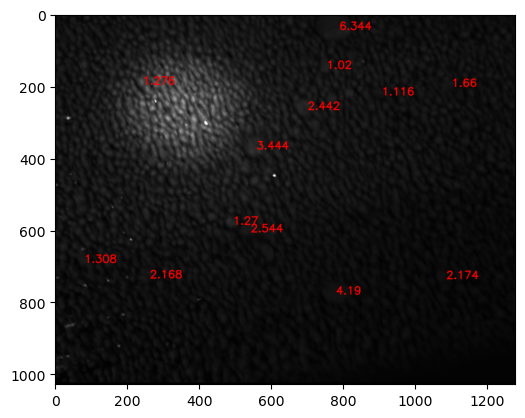

In [ ]:
plt.imshow(add_area_labels(image, res[0]))

## Real-time

In [ ]:
import cv2
from IPython.display import display, Image

def process_and_display(file, func=None):
    if func is None:  func = lambda x: x

    video = cv2.VideoCapture(file)

    display_handle = display(None, display_id=True)
    try:
        while True:
            _, frame = video.read()
            if frame is None:
                break
            _, frame = cv2.imencode('.jpeg', func(frame))
            display_handle.update(Image(data=frame.tobytes(), width=500, height=400))
    except KeyboardInterrupt:
        print('Get keyboard interrupt')
    finally:
        video.release()

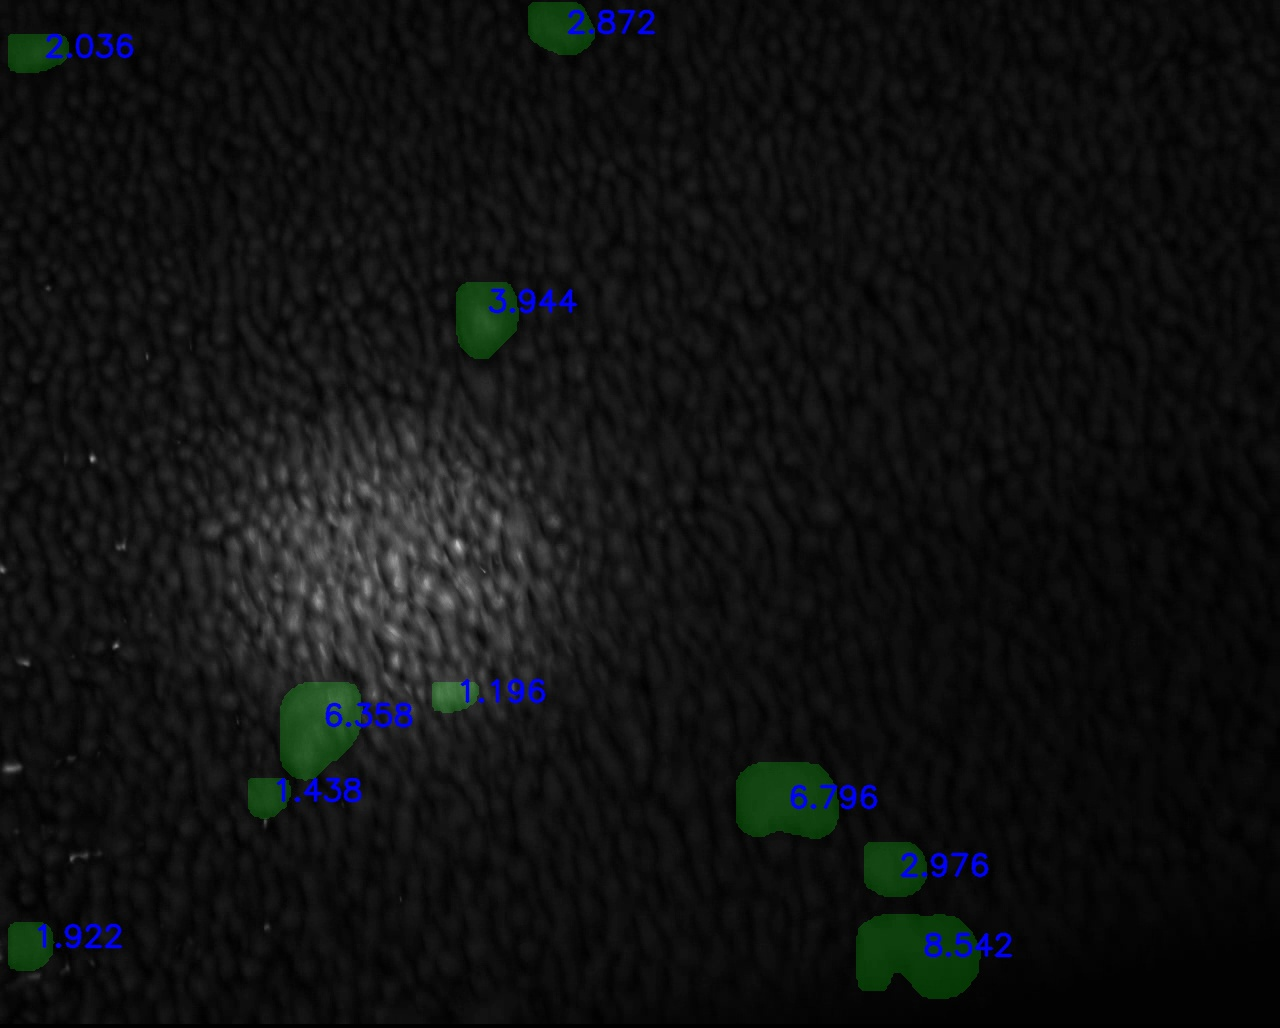

Get keyboard interrupt


In [ ]:
def segment_frame(frame): 
    res = yolo(frame, verbose=False)[0]
    return add_area_labels(merge_with_mask(frame,get_mask(res)), res)

process_and_display('../data/clods.mp4', segment_frame)

## Tracking

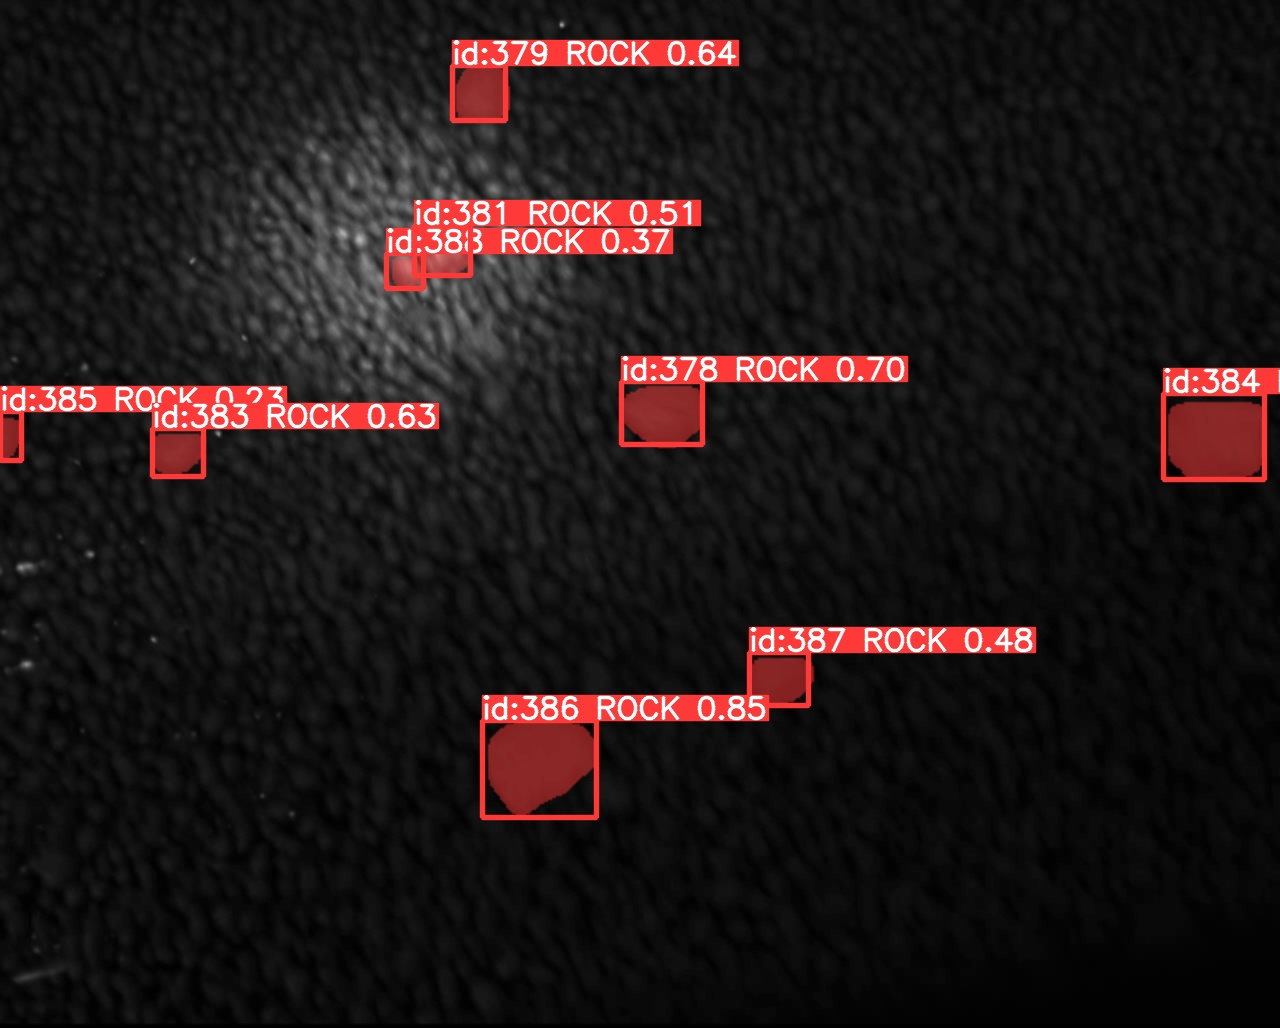

Get keyboard interrupt


In [ ]:
import cv2

video = cv2.VideoCapture('../data/clods.mp4')

display_handle = display(None, display_id=True)
try:
    while True:
        _, frame = video.read()
        if frame is None:
            break
        results = yolo.track(frame, persist=True, verbose=False)
        _, frame = cv2.imencode('.jpeg', results[0].plot())
        display_handle.update(Image(data=frame.tobytes(), width=500, height=400))
except KeyboardInterrupt:
    print('Get keyboard interrupt')
finally:
    video.release()